In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
f = 'data/top_locations_time_series.csv'

df = pd.read_csv(f)
df.head()

,hex6,2015-01-04 00:00:00,2015-01-11 00:00:00,2015-01-18 00:00:00,2015-01-25 00:00:00,2015-02-01 00:00:00,2015-02-08 00:00:00,2015-02-15 00:00:00,2015-02-22 00:00:00,2015-03-01 00:00:00,...,2019-11-03 00:00:00,2019-11-10 00:00:00,2019-11-17 00:00:00,2019-11-24 00:00:00,2019-12-01 00:00:00,2019-12-08 00:00:00,2019-12-15 00:00:00,2019-12-22 00:00:00,2019-12-29 00:00:00,2020-01-05 00:00:00
0,862a06927ffffff,16.842105,32.210526,28.000000,12.052632,10.105263,19.210526,23.789474,40.631579,33.263158,...,84.000000,131.631579,76.894737,10.894737,14.789474,23.368421,20.052632,41.631579,208.421053,24.421053
1,862a0692fffffff,16.842105,31.263158,28.000000,12.052632,10.105263,19.473684,23.789474,40.631579,33.263158,...,84.000000,131.789474,76.894737,11.000000,14.789474,23.631579,20.052632,41.631579,207.368421,24.421053
2,862a06967ffffff,18.157895,33.789474,28.842105,12.052632,10.105263,20.315789,23.789474,49.894737,33.263158,...,87.526316,160.315789,67.000000,12.526316,16.947368,24.157895,20.052632,26.578947,217.052632,24.421053
3,862a06977ffffff,16.842105,31.210526,28.000000,12.052632,10.105263,19.473684,23.789474,40.631579,33.263158,...,84.000000,131.789474,76.000000,11.000000,14.789474,23.631579,20.052632,41.421053,207.105263,24.421053
4,862a06d97ffffff,27.842105,20.105263,21.421053,26.631579,20.263158,28.842105,13.105263,47.684211,40.421053,...,56.421053,74.000000,108.421053,38.210526,132.736842,56.842105,67.631579,37.210526,55.526316,6.736842


In [3]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-01-04 00:00:00 to 2020-01-05 00:00:00


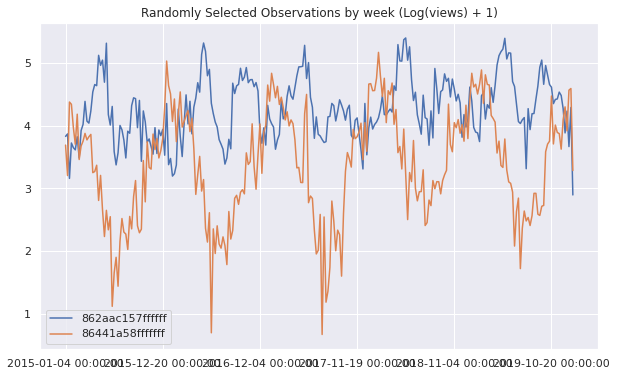

In [4]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['hex6'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Observations by week (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 2)

# Week Resample

In [5]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(weeks=pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date) - timedelta(weeks=pred_steps) 

val_pred_start = last_day - pred_length + timedelta(weeks=1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(weeks=1) 

# Add test period
test_pred_start = val_pred_end + timedelta(weeks=1)
# test_pred_start = val_pred_end
test_pred_end   = pd.to_datetime(data_end_date)

In [6]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(weeks=1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(weeks=1)

# Add test period
# Encode on all available data
test_enc_start = train_enc_start
test_enc_end = val_pred_end

In [50]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')

print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end, '\n')

print('Test encoding:', test_enc_start, '-', test_enc_end)
print('Test prediction:', test_pred_start, '-', test_pred_end)

print(f'\nEncoding interval: {enc_length.days//7}')
print(f'Prediction interval: {pred_length.days//7}')

Train encoding: 2015-01-04 00:00:00 - 2019-03-17 00:00:00
Train prediction: 2019-03-24 00:00:00 - 2019-06-23 00:00:00 

Val encoding: 2015-04-12 00:00:00 - 2019-06-23 00:00:00
Val prediction: 2019-06-30 00:00:00 - 2019-09-29 00:00:00 

Test encoding: 2015-01-04 00:00:00 - 2019-09-29 00:00:00
Test prediction: 2019-10-06 00:00:00 - 2020-01-05 00:00:00

Encoding interval: 220
Prediction interval: 14


In [51]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

## Model

In [10]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':14})(x)

model = Model(history_seq, pred_seq_train)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080  

In [12]:
first_n_samples = 40000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 3s 2s/step - loss: 0.7536 - val_loss: 0.4907
Epoch 2/10
2/2 [==============================] - 3s 1s/step - loss: 0.5384 - val_loss: 0.4042
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.4236 - val_loss: 0.4283
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.4458 - val_loss: 0.3903
Epoch 5/10
2/2 [==============================] - 3s 1s/step - loss: 0.3704 - val_loss: 0.3592
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 0.3448 - val_loss: 0.3514
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 0.3433 - val_loss: 0.3383
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.3156 - val_loss: 0.3364
Epoch 9/10
2/2 [==============================] - 2s 1s/step - loss: 0.3153 - val_loss: 0.3385
Epoch 10/10
2/2 [==============================] - 3s 1s/step - loss: 0.3182 - val_loss: 0.3229


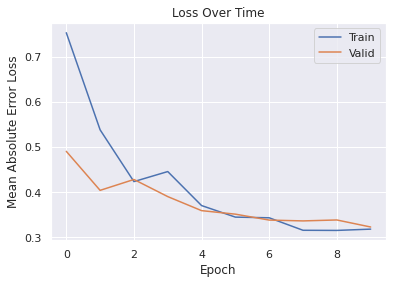

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
type(model)

In [16]:
type(history)

tensorflow.python.keras.callbacks.History

### Save / Load Model

In [12]:
from tensorflow.keras.models import load_model
# Save / Load model

model_name = 'birding-cnn'
# model.save(model_name)
model = load_model(model_name)

In [52]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [53]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [54]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

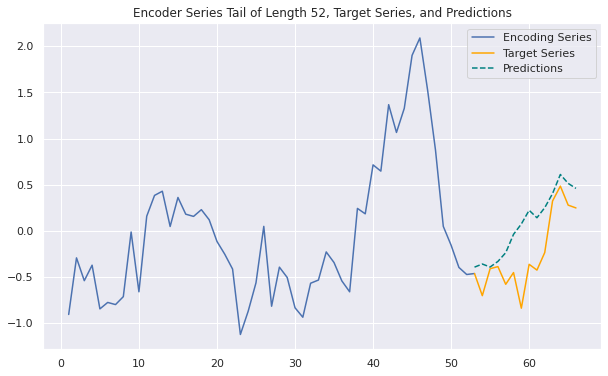

In [55]:
predict_and_plot(encoder_input_data, decoder_target_data, 100, 52)

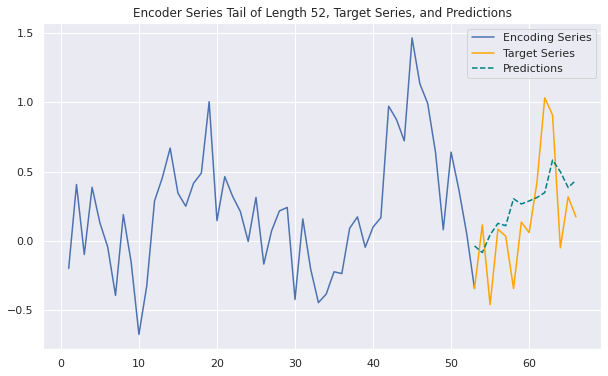

In [26]:
predict_and_plot(encoder_input_data, decoder_target_data, 220, 52)

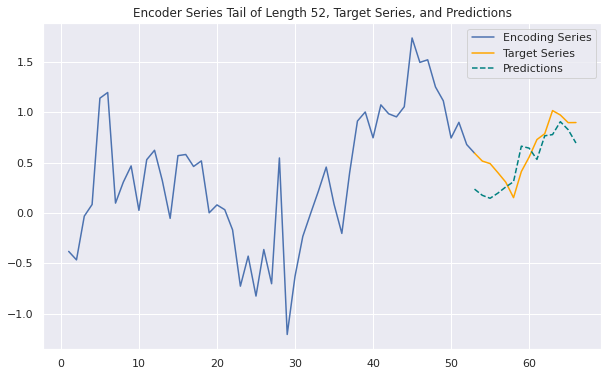

In [27]:
predict_and_plot(encoder_input_data, decoder_target_data, 1000, 52)

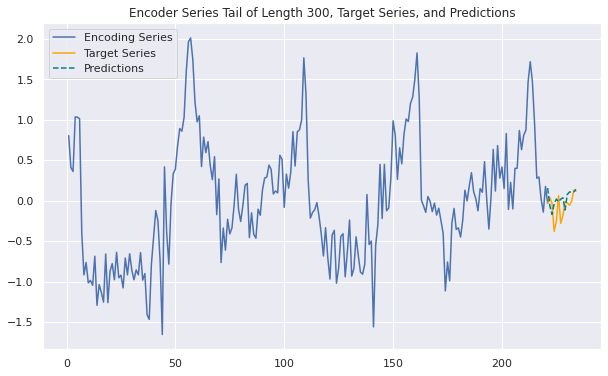

In [28]:
predict_and_plot(encoder_input_data, decoder_target_data, 2000, 300)

In [20]:
# Predict
# Find MAE

In [57]:
encoder_input_data = get_time_block_series(series_array, date_to_index, test_enc_start, test_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, test_pred_start, test_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

## MAE on Test Period

In [56]:
from tqdm.notebook import trange, tqdm

In [33]:
def mae(encoder_input_data, decoder_target_data, sample_ind):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    return np.mean(np.abs(pred_series - target_series))

In [36]:
%%time

mae_lst = []
for idx, _ in tqdm(enumerate(encoder_input_data)):
    m = mae(encoder_input_data, decoder_target_data, idx)
    mae_lst.append(m)
    
np.mean(mae_lst)


CPU times: user 3h 13min 44s, sys: 3h 11min 59s, total: 6h 25min 43s
Wall time: 48min 43s


0.37704078223153803

In [61]:
test_mae = np.mean(mae_lst)

print(f'Test MAE: {test_mae}')

Test MAE: 0.37704078223153803


In [39]:
df_predictions = pd.DataFrame(mae_lst)
df_predictions.to_csv('mae.csv')
df_predictions.head()

,0
0,0.421900
1,0.423453
2,0.353495
3,0.420433
4,0.270477


In [ ]:
## Best Predictions

In [46]:
best_predictions = list(df_predictions.nsmallest(5, 0).index)

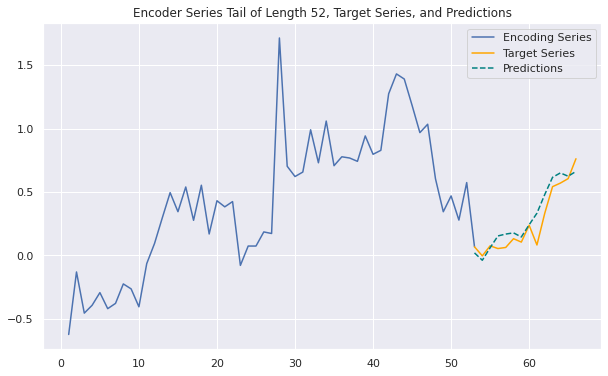

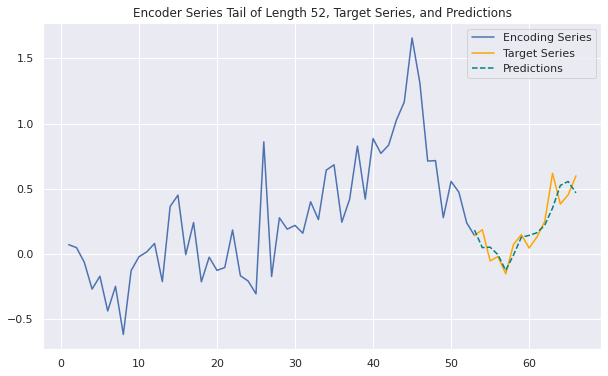

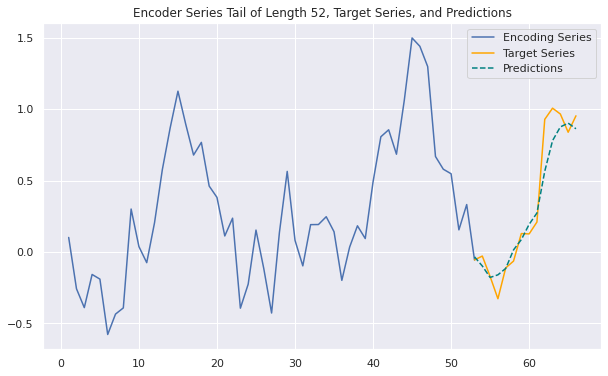

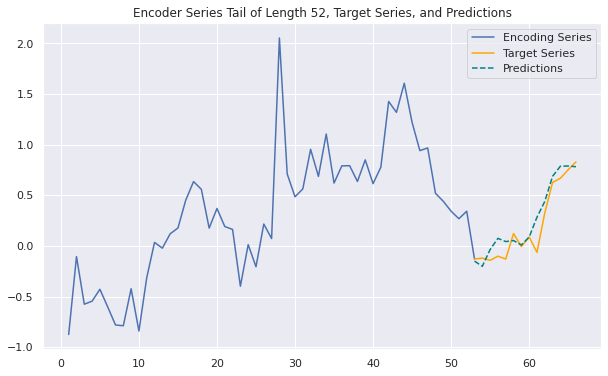

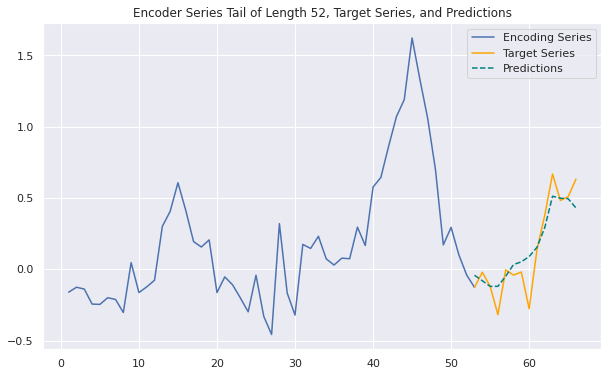

In [47]:
for i in best_predictions:
    predict_and_plot(encoder_input_data, decoder_target_data, i, 52)

## Worst Predictions

In [48]:
worst_predictions = list(df_predictions.nlargest(5, 0).index)

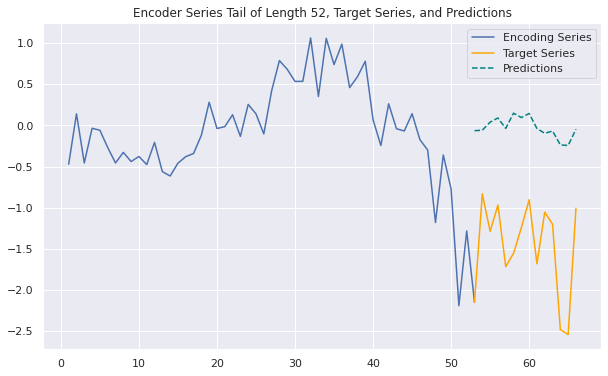

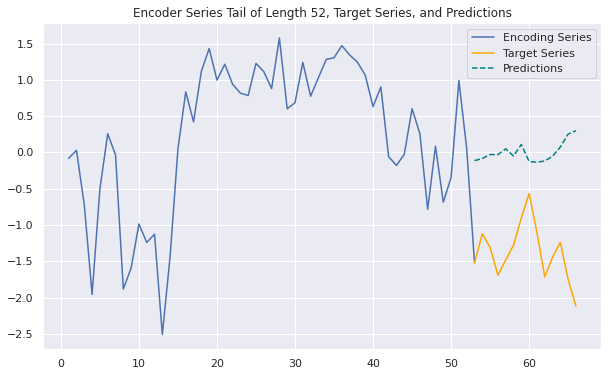

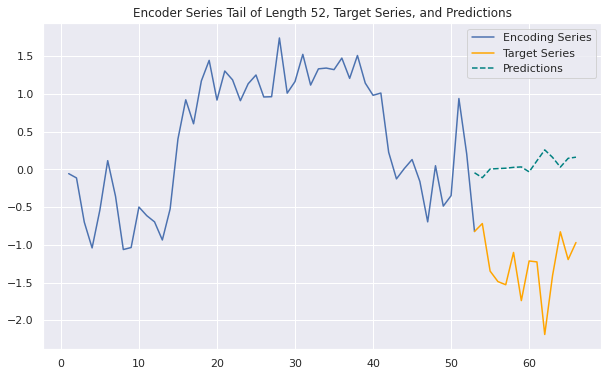

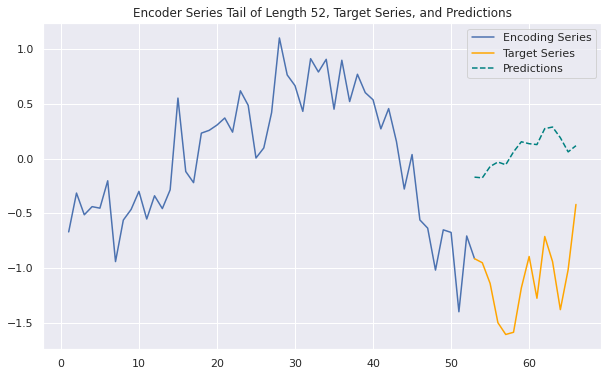

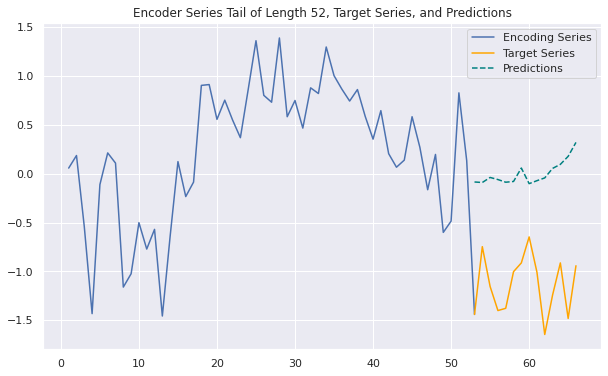

In [49]:
for i in worst_predictions:
    predict_and_plot(encoder_input_data, decoder_target_data, i, 52)

## Cacl MAE on sample

In [89]:
%%time

n_samples = 50
sample_selection = np.random.randint(0, len(encoder_input_data) + 1, n_samples)


mae_lst = []
for i in tqdm(range(n_samples)):
    m = mae(encoder_input_data, decoder_target_data, sample_selection[i])
    mae_lst.append(m)
    
np.mean(mae_lst)


CPU times: user 2min 11s, sys: 2min 24s, total: 4min 36s
Wall time: 34.7 s


0.4825187072736165

In [65]:
np.random.random_integers(5)

<ipython-input-65-fd8ba7eaeca0>:1: DeprecationWarning: This function is deprecated. Please call randint(1, 5 + 1) instead
  np.random.random_integers(5)


1

In [76]:
np.random.randint(0, len(encoder_input_data) + 1, 10)

array([1054, 3050, 1683, 3791, 3421,  828, 3397, 4281, 4253,  448])